## 获取所有掩码

In [7]:
import os
import json
import numpy as np
import cv2

# 定义保存 JSON 文件的目录
json_dir = '/home/a6/vis/LDS/SAM/datasets/data'
# 定义保存掩码图像的目录
mask_dir = '/home/a6/vis/LDS/SAM/datasets/masks'

# 如果不存在 masks 文件夹，则创建它
if not os.path.exists(mask_dir):
    os.makedirs(mask_dir)

# 遍历目录中的所有文件
for filename in os.listdir(json_dir):
    if filename.endswith('.json'):
        # 构建完整文件路径
        filepath = os.path.join(json_dir, filename)
        
        # 加载 JSON 数据
        with open(filepath, 'r') as f:
            data = json.load(f)
        
        # 提取图像信息和标注
        image_path = data.get('imagePath', '').replace('.png', '')
        image_height = data.get('imageHeight', 1024)
        image_width = data.get('imageWidth', 1024)
        shapes = data.get('shapes', [])
        
        # 遍历 JSON 文件中的每个标注
        for idx, shape in enumerate(shapes):
            label = shape['label'].replace('_', '')  # 去除标签中的下划线
            points = shape['points']
            
            # 创建一个空的单通道掩码图像
            mask = np.zeros((image_height, image_width), dtype=np.uint8)
            
            # 将点转换为适合 cv2.fillPoly 的格式
            points = np.array([points], dtype=np.int32)
            
            # 在掩码图像上绘制多边形
            cv2.fillPoly(mask, points, color=255)
            
            # 定义输出掩码文件名
            mask_filename = f"{idx + 1}_{label}_{image_path}.png"
            mask_filepath = os.path.join(mask_dir, mask_filename)
            
            # 保存掩码图像
            cv2.imwrite(mask_filepath, mask)

print("掩码生成完成。")


掩码生成完成。


## 获取各个掩码的嵌入

In [8]:
import os
import torch
import numpy as np
from PIL import Image
from segment_anything import sam_model_registry
import cv2
import torch.nn.functional as F
import matplotlib.pyplot as plt

# 定义模型和路径
sam_checkpoint = '/home/a6/vis/LDS/SAM/weights/sam_vit_h_4b8939.pth'
model_type = 'vit_h'
device = 'cuda'

# 创建SAM模型
sam_model = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam_model.to(device=device)

# 定义输入图像和输出目录
image_dir = '/home/a6/vis/LDS/SAM/datasets/data'
output_dir = '/home/a6/vis/LDS/SAM/logs'
masks_dir = '/home/a6/vis/LDS/SAM/datasets/masks'
mask_vec_npy_dir = os.path.join(output_dir, 'npy_masks')

# 确保输出目录存在
os.makedirs(output_dir, exist_ok=True)
os.makedirs(mask_vec_npy_dir, exist_ok=True)

# 遍历图像目录中的所有图像文件
for image_filename in os.listdir(image_dir):
    if image_filename.lower().endswith(('png', 'jpg', 'jpeg')):
        # 加载图像
        image_path = os.path.join(image_dir, image_filename)
        image = Image.open(image_path).convert('RGB')

        # 转换图像为torch张量并预处理
        image_torch = torch.as_tensor(np.array(image), device=device)
        transformed_image = image_torch.permute(2, 0, 1).contiguous()[None, :, :, :]
        input_image = sam_model.preprocess(transformed_image)

        # 获取图像嵌入
        with torch.no_grad():
            image_embedding = sam_model.image_encoder(input_image)  # [B, C, H, W]
        
        # 获取嵌入的形状
        b, c, h, w = image_embedding.shape

        # 遍历 masks 目录中的所有文件
        for mask_filename in os.listdir(masks_dir):
            # 检查掩码文件名是否包含当前图像文件名的基名
            if os.path.splitext(image_filename)[0] in mask_filename and mask_filename.endswith('.png'):
                # 加载掩码
                mask_path = os.path.join(masks_dir, mask_filename)
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                mask = mask.astype(np.float32) / 255.0  # 归一化掩码到[0, 1]
    
                mask = torch.as_tensor(mask, device=device)[None, None, :, :]  # [1, 1, H, W]

                # 缩放特征和掩码
                rescale_factor = 4  # 4x 上采样/下采样
                t1, t2 = int(mask.shape[2] / rescale_factor), int(mask.shape[3] / rescale_factor)
                features_rescale = F.interpolate(image_embedding, size=[t1, t2], mode='bilinear')
                mask_rescale = F.interpolate(mask, size=[t1, t2], mode='bilinear')

                masked_feature = torch.mul(features_rescale, mask_rescale)
                masked_feature = masked_feature.view(b, c, -1)
                non_zero_count = torch.count_nonzero(masked_feature, dim=2)

                # 计算掩码的平均向量
                masked_avg_vec = masked_feature.sum(dim=2) / non_zero_count
                masked_avg_vec[torch.isnan(masked_avg_vec)] = 0

                # 保存掩码特征向量
                npy_data = masked_avg_vec.detach().cpu().numpy()
                single_mask_vec_path = os.path.join(mask_vec_npy_dir, os.path.splitext(mask_filename)[0] + '.npy')
                np.save(single_mask_vec_path, npy_data)

print("嵌入向量保存完成。")


/home/a6/anaconda3/envs/LDS/lib/python3.9/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


嵌入向量保存完成。


In [2]:
import os
import json
import numpy as np

# 定义存储 .npy 文件的目录和保存 JSON 文件的目录
npy_masks_dir = '/home/a6/vis/LDS/SAM/logs/npy_masks'
json_output_dir = '/home/a6/vis/LDS/SAM/logs/npy_jsons'

# 确保输出目录存在
os.makedirs(json_output_dir, exist_ok=True)

# 遍历 npy 文件夹中的所有 .npy 文件
for npy_filename in os.listdir(npy_masks_dir):
    if npy_filename.endswith('.npy'):
        # 构建 .npy 文件的完整路径
        npy_file_path = os.path.join(npy_masks_dir, npy_filename)
        
        # 加载 .npy 文件中的数据
        npy_data = np.load(npy_file_path)
        
        # 将 numpy 数组转换为列表，以便 JSON 序列化
        npy_data_list = npy_data.tolist()
        
        # 构建 JSON 文件的路径
        json_filename = os.path.splitext(npy_filename)[0] + '.json'
        json_file_path = os.path.join(json_output_dir, json_filename)
        
        # 保存数据到 JSON 文件，带有缩进和换行
        with open(json_file_path, 'w') as json_file:
            json.dump(npy_data_list, json_file, indent=4)
        
print("所有的 .npy 文件已转换为 JSON 文件并保存。")


所有的 .npy 文件已转换为 JSON 文件并保存。


In [11]:
# 加载必要的库
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import json
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler

# 定义加权特征网络
class WeightedFeatureNetwork(nn.Module):
    def __init__(self, input_dim):
        super(WeightedFeatureNetwork, self).__init__()
        # 初始化权重向量，初始值为1
        self.weights = nn.Parameter(torch.ones(input_dim))

    def forward(self, x):
        # 对输入特征向量进行加权
        weighted_x = x * self.weights
        return weighted_x

# 定义三元组损失函数
def triplet_loss(anchor, positive, negative, margin=1.0):
    # 计算锚点与正样本之间的距离
    pos_dist = F.pairwise_distance(anchor, positive)
    # 计算锚点与负样本之间的距离
    neg_dist = F.pairwise_distance(anchor, negative)
    # 计算三元组损失
    loss = F.relu(pos_dist - neg_dist + margin)
    return loss.mean()

# 创建三元组样本
def create_triplet_samples(features, labels):
    """
    从特征和标签中生成三元组样本（锚点、正样本、负样本）。
    """
    triplets = []
    num_samples = len(labels)
    for i in range(num_samples):
        anchor = features[i]
        positive_idx = np.random.choice(np.where(labels == labels[i])[0])
        negative_idx = np.random.choice(np.where(labels != labels[i])[0])
        triplets.append((anchor, features[positive_idx], features[negative_idx]))
    return triplets

# 训练网络
def train_network(image_names, npy_masks_dir, epochs=200, lr=0.1):
    """
    训练加权特征网络，使用三元组损失优化权重向量。
    """
    model = None

    for epoch in range(epochs):
        total_epoch_loss = 0
        num_samples = 0
        
        for image_name in image_names:
            # 加载特征和标签
            features, labels = load_features_and_labels(npy_masks_dir, image_name)
            
            # 标准化特征向量
            scaler = StandardScaler()
            features = scaler.fit_transform(features)
            
            if model is None:
                input_dim = features.shape[1]
                model = WeightedFeatureNetwork(input_dim)
                optimizer = optim.Adam(model.parameters(), lr=lr)
            
            # 创建三元组样本
            triplets = create_triplet_samples(features, labels)
        
            # 计算三元组损失
            for anchor, positive, negative in triplets:
                optimizer.zero_grad()  # 每个样本的梯度单独计算
                anchor = torch.tensor(anchor, dtype=torch.float32)
                positive = torch.tensor(positive, dtype=torch.float32)
                negative = torch.tensor(negative, dtype=torch.float32)
                anchor = model(anchor)
                positive = model(positive)
                negative = model(negative)
                loss = triplet_loss(anchor, positive, negative)
                loss.backward()
                optimizer.step()
                total_epoch_loss += loss.item()  # 累加总的 epoch 损失
                num_samples += 1
        
        # 取均值
        average_epoch_loss = total_epoch_loss / num_samples
        print(f"Epoch {epoch+1}/{epochs}, Loss: {average_epoch_loss}")

    return model

# 定义标签映射字典
label_mapping = {
    'background': 0,
    'pore': 1
}

# 加载特征和标签
def load_features_and_labels(npy_masks_dir, image_name):
    """
    从指定目录中加载特定图像的特征和标签，并将标签转换为数值。
    """
    features = []
    labels = []
    for npy_filename in os.listdir(npy_masks_dir):
        if image_name in npy_filename and npy_filename.endswith('.npy'):
            npy_file_path = os.path.join(npy_masks_dir, npy_filename)
            npy_data = np.load(npy_file_path)
            features.append(npy_data.flatten())
            label_str = npy_filename.split('_')[1]  # 获取字符标签
            label = label_mapping[label_str]  # 转换为数值标签
            labels.append(label)
    return np.array(features), np.array(labels)

# 从 train.txt 中加载图像名称
def load_image_names(train_txt_path):
    """
    从 train.txt 文件中读取所有图像名称。
    """
    with open(train_txt_path, 'r') as f:
        image_names = [line.strip() for line in f]
    return image_names

# 主程序
npy_masks_dir = '/home/a6/vis/LDS/SAM/logs/npy_masks'
train_txt_path = '/home/a6/vis/LDS/SAM/datasets/train.txt'  # train.txt 文件路径

# 加载所有图像名称
image_names = load_image_names(train_txt_path)
print(image_names)

# 训练网络
model = train_network(image_names, npy_masks_dir, epochs=70, lr=0.001)

# 将权重保存为 JSON 文件
weights = model.weights.detach().cpu().numpy().tolist()
json_output_path = '/home/a6/vis/LDS/SAM/logs/weights.json'
with open(json_output_path, 'w') as json_file:
    json.dump(weights, json_file)

print(f"权重已保存至 {json_output_path}")


['X2-D18m3-', 'X2-E20m1-', 'S1-B12m2-', 'X2-G25m2-', 'S1-B6m2-']
Epoch 1/70, Loss: 1.757365909994465
Epoch 2/70, Loss: 1.7275429973863576
Epoch 3/70, Loss: 1.4324209422281344
Epoch 4/70, Loss: 1.4255656568971398
Epoch 5/70, Loss: 1.3124800930284475
Epoch 6/70, Loss: 1.5950448075385943
Epoch 7/70, Loss: 1.5283995432396458
Epoch 8/70, Loss: 1.3488211932247631
Epoch 9/70, Loss: 1.4329098949693653
Epoch 10/70, Loss: 1.3461606247784341
Epoch 11/70, Loss: 1.320735928783678
Epoch 12/70, Loss: 1.2869115306906505
Epoch 13/70, Loss: 1.2375731089343764
Epoch 14/70, Loss: 1.130473609819804
Epoch 15/70, Loss: 1.117173210562092
Epoch 16/70, Loss: 1.0571984251884565
Epoch 17/70, Loss: 1.1836382121255953
Epoch 18/70, Loss: 1.1530609731804835
Epoch 19/70, Loss: 0.8955961906746642
Epoch 20/70, Loss: 1.0058471444534929
Epoch 21/70, Loss: 1.0105072674685962
Epoch 22/70, Loss: 1.0843187697946208
Epoch 23/70, Loss: 0.8914770844864519
Epoch 24/70, Loss: 0.9829633634384364
Epoch 25/70, Loss: 0.958407899778183

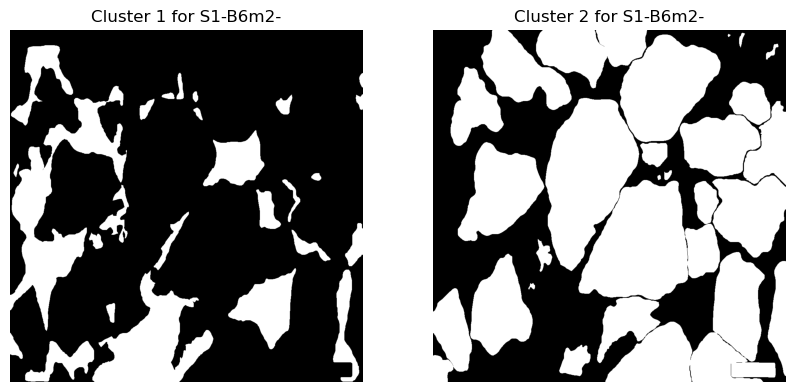

In [12]:
import os
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import cv2
import json

# 指定图像名称
image_name = "S1-B6m2-"

# 定义目录路径
npy_masks_dir = '/home/a6/vis/LDS/SAM/logs/npy_masks'
masks_dir = '/home/a6/vis/LDS/SAM/datasets/masks'
weights_path = '/home/a6/vis/LDS/SAM/logs/weights.json'

# 加载权重
with open(weights_path, 'r') as f:
    weights = np.array(json.load(f))
    # weights = np.ones((1,256))

# 获取所有相关的npy文件
npy_files = [f for f in os.listdir(npy_masks_dir) if image_name in f and f.endswith('.npy')]

# 加载特征向量
features = []
mask_names = []
for npy_file in npy_files:
    feature_path = os.path.join(npy_masks_dir, npy_file)
    feature = np.load(feature_path).flatten()
    features.append(feature)
    mask_names.append(os.path.splitext(npy_file)[0])

# 将特征向量转换为 NumPy 数组
features = np.array(features)

# 对特征进行标准化
scaler = StandardScaler()
features = scaler.fit_transform(features)

# 对标准化后的特征进行加权
weighted_features = features * weights

# 二分类聚类
kmeans = KMeans(n_clusters=2, random_state=0).fit(weighted_features)
labels = kmeans.labels_

# 初始化图像大小，假设所有掩码大小一致
mask_example_path = os.path.join(masks_dir, mask_names[0] + '.png')
mask_example = cv2.imread(mask_example_path, cv2.IMREAD_GRAYSCALE)
mask_shape = mask_example.shape

# 分别初始化两个结果图像
result_image1 = np.zeros(mask_shape, dtype=np.uint8)
result_image2 = np.zeros(mask_shape, dtype=np.uint8)

# 绘制聚类结果
for label, mask_name in zip(labels, mask_names):
    mask_path = os.path.join(masks_dir, mask_name + '.png')
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    if label == 0:
        result_image1[mask > 0] = 255  # 类别1
    else:
        result_image2[mask > 0] = 255  # 类别2

# 在Jupyter中展示结果
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(result_image1, cmap='gray')
plt.title(f'Cluster 1 for {image_name}')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(result_image2, cmap='gray')
plt.title(f'Cluster 2 for {image_name}')
plt.axis('off')

plt.show()


(251, 256)


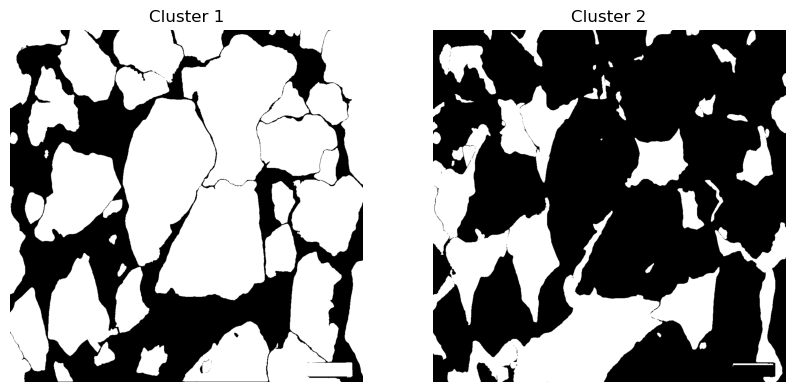

In [6]:
import os
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import cv2
import json

# 定义目录路径
npy_masks_dir = '/home/a6/vis/LDS/SAM/outputs/npy_masks'
masks_dir = '/home/a6/vis/LDS/SAM/masks'
weights_path = '/home/a6/vis/LDS/SAM/logs/weights.json'

# 加载权重
with open(weights_path, 'r') as f:
    weights = np.array(json.load(f))
    # weights = np.ones(256)

# 获取所有 .npy 文件
npy_files = [f for f in os.listdir(npy_masks_dir) if f.endswith('.npy')]

# 加载特征向量
features = []
mask_names = []
for npy_file in npy_files:
    feature_path = os.path.join(npy_masks_dir, npy_file)
    feature = np.load(feature_path).flatten()
    features.append(feature)
    mask_names.append(os.path.splitext(npy_file)[0])

# 将特征向量转换为 NumPy 数组
features = np.array(features)
print(features.shape)

# 对特征进行标准化
scaler = StandardScaler()
features = scaler.fit_transform(features)

# 对标准化后的特征进行加权
weighted_features = features * weights

# 二分类聚类
kmeans = KMeans(n_clusters=2, n_init=100, random_state=0).fit(weighted_features)
labels = kmeans.labels_

# 初始化图像大小，假设所有掩码大小一致
mask_example_path = os.path.join(masks_dir, mask_names[0] + '.png')
mask_example = cv2.imread(mask_example_path, cv2.IMREAD_GRAYSCALE)
mask_shape = mask_example.shape

# 分别初始化两个结果图像
result_image1 = np.zeros(mask_shape, dtype=np.uint8)
result_image2 = np.zeros(mask_shape, dtype=np.uint8)

# 绘制聚类结果
for label, mask_name in zip(labels, mask_names):
    mask_path = os.path.join(masks_dir, mask_name + '.png')
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    if label == 0:
        result_image1[mask > 0] = 255  # 类别1
    else:
        result_image2[mask > 0] = 255  # 类别2

# 在Jupyter中展示结果
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(result_image1, cmap='gray')
plt.title('Cluster 1')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(result_image2, cmap='gray')
plt.title('Cluster 2')
plt.axis('off')

plt.show()


(84, 256)


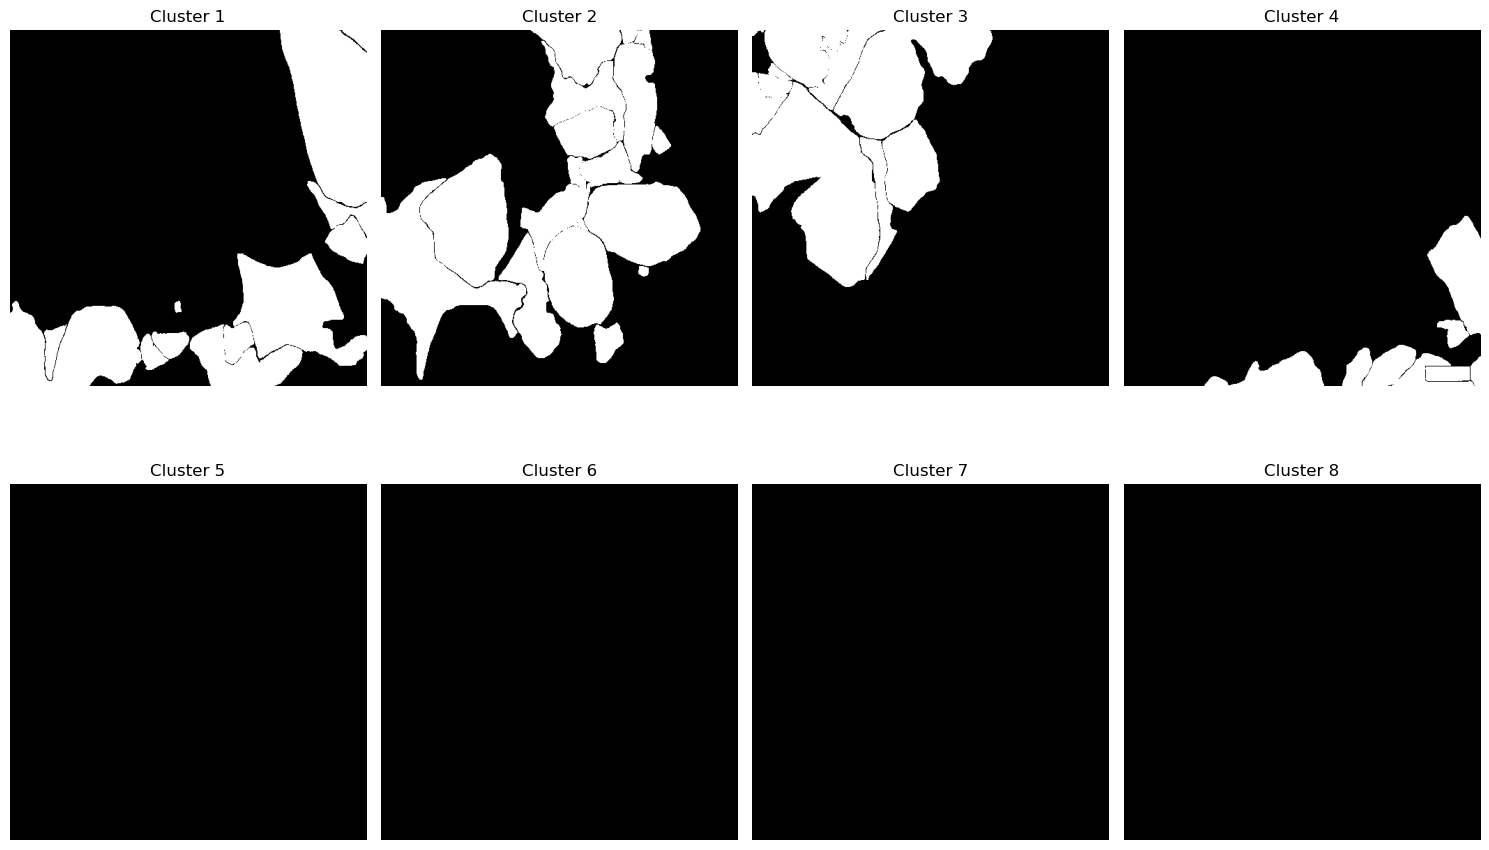

In [18]:
import os
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import cv2
import json

# 定义目录路径
npy_masks_dir = '/home/a6/vis/LDS/SAM/outputs/npy_masks'
masks_dir = '/home/a6/vis/LDS/SAM/masks'
weights_path = '/home/a6/vis/LDS/SAM/logs/weights.json'

# 加载权重
with open(weights_path, 'r') as f:
    weights = np.array(json.load(f))
    # weights = np.ones(256)

# 获取所有 .npy 文件
npy_files = [f for f in os.listdir(npy_masks_dir) if f.endswith('.npy')]

# 加载特征向量
features = []
mask_names = []
for npy_file in npy_files:
    feature_path = os.path.join(npy_masks_dir, npy_file)
    feature = np.load(feature_path).flatten()
    features.append(feature)
    mask_names.append(os.path.splitext(npy_file)[0])

# 将特征向量转换为 NumPy 数组
features = np.array(features)
print(features.shape)

# 对特征进行标准化
scaler = StandardScaler()
features = scaler.fit_transform(features)

# 对标准化后的特征进行加权
weighted_features = features * weights

# 聚类为15类
kmeans = KMeans(n_clusters=4, n_init=10, random_state=0).fit(weighted_features)
labels = kmeans.labels_

# 初始化图像大小，假设所有掩码大小一致
mask_example_path = os.path.join(masks_dir, mask_names[0] + '.png')
mask_example = cv2.imread(mask_example_path, cv2.IMREAD_GRAYSCALE)
mask_shape = mask_example.shape

# 初始化结果图像列表
result_images = [np.zeros(mask_shape, dtype=np.uint8) for _ in range(8)]

# 绘制聚类结果
for label, mask_name in zip(labels, mask_names):
    mask_path = os.path.join(masks_dir, mask_name + '.png')
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    result_images[label][mask > 0] = 255  # 设置相应类别的结果图像

# 在Jupyter中展示结果
plt.figure(figsize=(15, 10))
for i, result_image in enumerate(result_images):
    plt.subplot(2, 4, i + 1)
    plt.imshow(result_image, cmap='gray')
    plt.title(f'Cluster {i + 1}')
    plt.axis('off')

plt.tight_layout()
plt.show()


(251, 256)
[4.07573958 3.325954   3.53522662 2.86529655 5.06639526 3.22187433
 1.95288247 2.96871885 4.75618419 3.65749696 3.86675389 2.60596154
 3.98113489 3.74902388 4.25127654 1.947182   2.9705472  3.12572484
 3.97874704 3.82122693 3.52960342 3.55783457 2.86929845 4.08468761
 3.46591435 3.63567993 3.73920796 3.69066171 2.82546974 3.60052656
 3.02491701 3.62170768 3.51373527 6.38922766 3.23445549 3.62093753
 2.86938156 4.45921808 2.64498588 2.73887051 2.16188624 3.44317093
 3.4720492  2.57041332 2.98965385 2.76910835 4.49781818 4.22608275
 3.42011193 2.55911993 3.73706418 2.70982239 3.50289995 4.05625281
 4.26890678 3.77533296 3.26319946 3.80152263 3.57789992 3.90888385
 5.07066248 3.45940315 2.15391524 2.39427771 2.42052319 2.48778685
 4.00672714 4.08518265 3.42408583 3.24694451 3.15860067 4.06307739
 4.26275109 4.55144423 2.79330801 3.8126631  2.83402392 2.84559402
 4.23311147 2.9131957  4.21432924 4.61556214 3.73657554 4.07515935
 2.19543094 2.71746769 2.86912966 2.8349429  3.6903

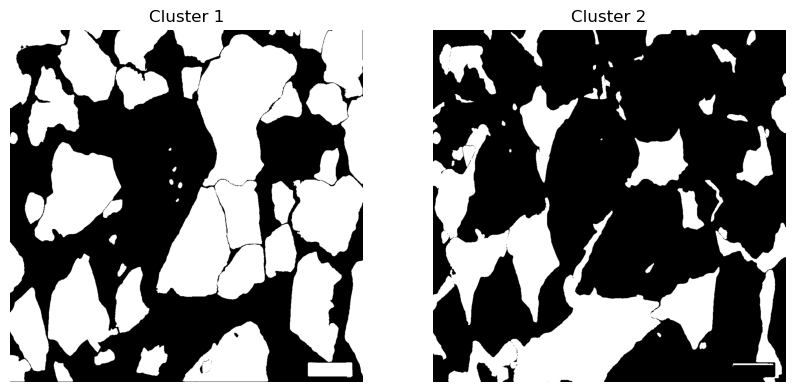

In [7]:
import os
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import cv2
import json

# 定义目录路径
npy_masks_dir = '/home/a6/vis/LDS/SAM/outputs/npy_masks'
masks_dir = '/home/a6/vis/LDS/SAM/masks'
weights_path = '/home/a6/vis/LDS/SAM/logs/weights.json'

# 加载权重
with open(weights_path, 'r') as f:
    weights = np.array(json.load(f))
    # weights = np.ones(256)

# 获取所有 .npy 文件
npy_files = [f for f in os.listdir(npy_masks_dir) if f.endswith('.npy')]

# 加载特征向量
features = []
mask_names = []
for npy_file in npy_files:
    feature_path = os.path.join(npy_masks_dir, npy_file)
    feature = np.load(feature_path).flatten()
    features.append(feature)
    mask_names.append(os.path.splitext(npy_file)[0])

# 将特征向量转换为 NumPy 数组
features = np.array(features)
print(features.shape)

# 对特征进行标准化
scaler = StandardScaler()
features = scaler.fit_transform(features)

# 对标准化后的特征进行加权
weighted_features = features * weights

# 二分类聚类
kmeans = KMeans(n_clusters=2, n_init=100, random_state=0).fit(weighted_features)
labels = kmeans.labels_
distances = kmeans.transform(weighted_features)  # 距离每个聚类中心的距离
confidence_scores = np.min(distances, axis=1)  # 取每个样本到其所属聚类中心的距离

# 计算IoU
def calculate_iou(box1, box2):
    x1, y1, x2, y2 = box1
    x1_, y1_, x2_, y2_ = box2

    inter_x1 = max(x1, x1_)
    inter_y1 = max(y1, y1_)
    inter_x2 = min(x2, x2_)
    inter_y2 = min(y2, y2_)

    inter_area = max(0, inter_x2 - inter_x1 + 1) * max(0, inter_y2 - inter_y1 + 1)
    box1_area = (x2 - x1 + 1) * (y2 - y1 + 1)
    box2_area = (x2_ - x2 + 1) * (y2_ - y1 + 1)

    iou = inter_area / float(box1_area + box2_area - inter_area)
    return iou

# 提取边界框
def get_bounding_box(mask):
    coords = cv2.findNonZero(mask)
    x, y, w, h = cv2.boundingRect(coords)
    return x, y, x + w - 1, y + h - 1

# 处理每个类别的掩码
result_images = [np.zeros(mask_shape, dtype=np.uint8) for _ in range(2)]

for label_id in range(2):  # 处理每个类别
    class_masks = []
    class_scores = []
    class_names = []

    for label, mask_name, score in zip(labels, mask_names, confidence_scores):
        if label == label_id:
            mask_path = os.path.join(masks_dir, mask_name + '.png')
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            class_masks.append(mask)
            class_scores.append(score)
            class_names.append(mask_name)

    # 非极大值抑制
    selected_indices = []
    sorted_indices = np.argsort(class_scores)
    while len(sorted_indices) > 0:
        current = sorted_indices[0]
        selected_indices.append(current)
        current_box = get_bounding_box(class_masks[current])
        sorted_indices = sorted_indices[1:]

        suppress = []
        for idx in sorted_indices:
            box = get_bounding_box(class_masks[idx])
            iou = calculate_iou(current_box, box)
            if iou > 0.4:
                suppress.append(idx)
        
        sorted_indices = [i for i in sorted_indices if i not in suppress]

    # 保留选中的掩码
    for idx in selected_indices:
        result_images[label_id][class_masks[idx] > 0] = 255
        print(f"Retained: {class_names[idx]} with confidence {class_scores[idx]}")

# 在Jupyter中展示结果
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(result_images[0], cmap='gray')
plt.title('Cluster 1')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(result_images[1], cmap='gray')
plt.title('Cluster 2')
plt.axis('off')

plt.show()
